In [1]:
# Load necessary libraries and tools...

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import math
import psycopg2 as psy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import pandas.io.sql as psql
%matplotlib inline


In [2]:
# Loading data from csv files...

In [3]:
cohort_1_w1w2 = pd.read_csv('/Users/cguy/kelstuff/ga_summer_2016/cohort_1_w1w2.csv')
cohort_1_w1w2.head()

/Users/cguy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,9,10,11,12,16,20,23,26,29,30,31,32,33,36,38,39,40,41,43,44,45,46,51,52,53,56,59,60,62,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,AcSuppSv,AgeMP,AmIAKN,Asian,Baseline,BlkAfrAm,BudgetSv,CareerSv,CurrFTE,...,Sex,SpecEdSv,St,StFCID,StFIPS,SubAbuse,TribeSv,Wave,Weight,White
0,0,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450290395006,2.0,Yes,0.0,Wave 1: Age 17 Baseline Survey,1.26,1.0
1,4,0.0,17.0,1.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450448396586,2.0,No,1.0,Wave 1: Age 17 Baseline Survey,1.36,0.0
2,10,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450540097503,2.0,No,0.0,Wave 1: Age 17 Baseline Survey,1.26,1.0
3,14,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,1.0,0.0,AK,AK450652098623,2.0,No,0.0,Wave 1: Age 17 Baseline Survey,3.31,1.0
4,17,0.0,17.0,1.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,1.0,AK,AK451448406587,2.0,No,1.0,Wave 1: Age 17 Baseline Survey,1.36,0.0


In [4]:
cohort_1_w1w2.columns

Index([u'Unnamed: 0', u'AcSuppSv', u'AgeMP', u'AmIAKN', u'Asian', u'Baseline',
       u'BlkAfrAm', u'BudgetSv', u'CareerSv', u'CurrFTE', u'CurrPTE',
       u'CurrenRoll', u'DOB', u'DelinqntSv', u'EdLevlSv', u'EducFinaSv',
       u'Elig19', u'EmplyTrSv', u'FCStatSv', u'FY', u'FY11Cohort',
       u'FamSuppSv', u'HawaiiPI', u'HighEdCert', u'HisOrgin', u'HlthEdSv',
       u'Homeless', u'HousEdSv', u'ILNAsv', u'InSample', u'Incarc',
       u'Medicaid', u'MedicalIn', u'MentlHlthIn', u'MentorSv', u'Num_services',
       u'OthrFinAs', u'OthrFinaSv', u'OthrHlthIn', u'OutcmDte', u'OutcmFCS',
       u'OutcmRpt', u'PSEdSuppSv', u'PrescripIn', u'PubFinAs', u'PubFoodAs',
       u'PubHousAs', u'Race', u'RaceDcln', u'RaceEthn', u'RaceUnkn',
       u'RepDate_outcomes', u'RepDate_services', u'Responded', u'RmBrdFASv',
       u'SILsv', u'SampleState', u'Sex', u'SpecEdSv', u'St', u'StFCID',
       u'StFIPS', u'SubAbuse', u'TribeSv', u'Wave', u'Weight', u'White'],
      dtype='object')

# 1) Preprocess data and separate target variables from feature variables and demographics

In [5]:
# Seperate dataframe into feature vars and target vars

targets = cohort_1_w1w2[['PubFoodAs','PubHousAs','OthrFinAs','HighEdCert','CurrFTE','CurrPTE', \
                     'PubFinAs','CurrenRoll','PrescripIn','Homeless','SubAbuse','Incarc','Medicaid','OthrHlthIn','MedicalIn','MentlHlthIn', 'Wave']]


features = cohort_1_w1w2[['ILNAsv','AcSuppSv','PSEdSuppSv','CareerSv','EmplyTrSv','BudgetSv','HousEdSv','HlthEdSv',\
                     'FamSuppSv','MentorSv','SILsv','RmBrdFASv','EducFinaSv','OthrFinaSv','St','DelinqntSv','Wave']]

demographics = cohort_1_w1w2[['St','DelinqntSv','Sex','Race','TribeSv','EdLevlSv','SpecEdSv','RaceEthn','AgeMP','Wave']]
demographics_W1 = demographics[demographics.Wave == "Wave 1: Age 17 Baseline Survey"]
demographics_W2 = demographics[demographics.Wave == "Wave 2: Age 19 Followup"]

In [6]:
# # Create column for number of services received

services_count = features.T
services_count = services_count.drop('Wave')
services_count = services_count.drop('St')
services_count = services_count.drop('DelinqntSv')


features['Num_services'] = (services_count == 1).sum()
features.head(10)

/Users/cguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,St,DelinqntSv,Wave,Num_services
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,3
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,4
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2


In [7]:
# Let's focus on just W2 targets and features

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

features_2 = features.copy()

features_w2 = features_2[features_2.Wave == "Wave 2: Age 19 Followup"]
features_w2 = features_w2.drop('Wave', axis = 1)

features_w2['St'] = le.fit_transform(features_w2['St'])

features_w2.head()

,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,St,DelinqntSv,Num_services
7328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,2
7329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
7330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,3
7331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
7332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,2


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

demographics_W2_ = demographics_W2.drop('Wave', axis = 1)


demo_w2 = demographics_W2_.copy()

for column in demo_w2:
    demo_w2[column] = le.fit_transform(demo_w2[column])
demo_w2.head()

,St,DelinqntSv,Sex,Race,TribeSv,EdLevlSv,SpecEdSv,RaceEthn,AgeMP
7328,0,0,1,0,0,6,0,0,1
7329,0,0,1,2,1,6,0,2,1
7330,0,0,1,0,0,6,0,0,1
7331,0,0,0,0,0,6,0,0,1
7332,0,0,1,2,1,6,1,2,1


# 2) PCA over demographics

In [9]:
# y-correlations

x_corr = np.corrcoef(demo_w2.values.T)
demo_w2.corr()

,St,DelinqntSv,Sex,Race,TribeSv,EdLevlSv,SpecEdSv,RaceEthn,AgeMP
St,1.000000,0.157216,-0.012093,-0.161497,0.209669,0.101195,0.073206,-0.161297,-0.002047
DelinqntSv,0.157216,1.000000,-0.140376,0.003153,0.604808,0.387680,0.448362,0.057489,-0.079843
Sex,-0.012093,-0.140376,1.000000,0.038939,0.013893,0.045991,-0.073279,0.048073,-0.004911
Race,-0.161497,0.003153,0.038939,1.000000,0.086574,0.040234,-0.014258,0.663553,-0.034081
TribeSv,0.209669,0.604808,0.013893,0.086574,1.000000,0.514044,0.542995,0.104848,-0.103080
EdLevlSv,0.101195,0.387680,0.045991,0.040234,0.514044,1.000000,0.345044,0.058791,-0.002230
SpecEdSv,0.073206,0.448362,-0.073279,-0.014258,0.542995,0.345044,1.000000,0.004722,-0.069926
RaceEthn,-0.161297,0.057489,0.048073,0.663553,0.104848,0.058791,0.004722,1.000000,-0.012955
AgeMP,-0.002047,-0.079843,-0.004911,-0.034081,-0.103080,-0.002230,-0.069926,-0.012955,1.000000


In [10]:
# Obtaining eigenvalues and eigenvectors for PCA

eig_vals, eig_vecs = np.linalg.eig(x_corr)
print eig_vals
print eig_vecs


[ 2.50981246  1.74488092  0.31793581  0.34265792  0.52674708  0.62813836
  0.89164436  1.04012105  0.99806205]
[[ 0.16502751  0.30296124 -0.08254126  0.09563923  0.17157708 -0.05934223
  -0.88740455 -0.20850076  0.0331796 ]
 [ 0.49836619  0.04925076 -0.38072398  0.19199239 -0.73012923 -0.08153932
  -0.00716861  0.16289783  0.03269908]
 [-0.04715919 -0.09919475 -0.1036938   0.05197905 -0.15905829 -0.23087721
   0.16333732 -0.90952763 -0.20483839]
 [ 0.0596738  -0.66856155 -0.47574331 -0.51147362  0.12249479 -0.02029321
  -0.20987936  0.03412136  0.02995203]
 [ 0.55077807 -0.0118526   0.62708259 -0.52814587 -0.10419721 -0.06822675
  -0.01161628 -0.09149793 -0.01770992]
 [ 0.43511508 -0.00725579 -0.1485873   0.15637362  0.28120423  0.76268058
   0.17308601 -0.23709159  0.13100633]
 [ 0.45958491  0.06270177 -0.18741481  0.19751402  0.55077521 -0.57121872
   0.26696525  0.09897884 -0.00163823]
 [ 0.08345454 -0.66617883  0.40067299  0.58698832 -0.02729951 -0.04625526
  -0.19135336  0.0239750

In [11]:
# Obtaining cumulative explained variance

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print cum_var_exp

[ 27.88680506  47.27437088  58.83127142  69.92084971  79.82800924
  86.80732438  92.66006968  96.46737988 100.        ]


In [12]:
# From output of cell above, we can see 
# that the first two principal components explain 92.6% of the variance in the target variables

In [13]:
# Obtaining eigenpairs...

value_vector_pairs = [[eig_vals[i], eig_vecs[:,i]] for i in range(len(eig_vals))]
value_vector_pairs.sort(reverse=True)

In [14]:
# Transforming eigen data to obtain 2d PCA projection matrix in order to plot principal components

weight_2d_projection = np.hstack((value_vector_pairs[0][1].reshape(eig_vecs.shape[1],1),
                                  value_vector_pairs[1][1].reshape(eig_vecs.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection

Weight data 2d PCA projection matrix:
[[ 0.16502751  0.30296124]
 [ 0.49836619  0.04925076]
 [-0.04715919 -0.09919475]
 [ 0.0596738  -0.66856155]
 [ 0.55077807 -0.0118526 ]
 [ 0.43511508 -0.00725579]
 [ 0.45958491  0.06270177]
 [ 0.08345454 -0.66617883]
 [-0.08802013  0.03249337]]


In [15]:
Z = demo_w2.dot(weight_2d_projection)


### PC1 vs PC2

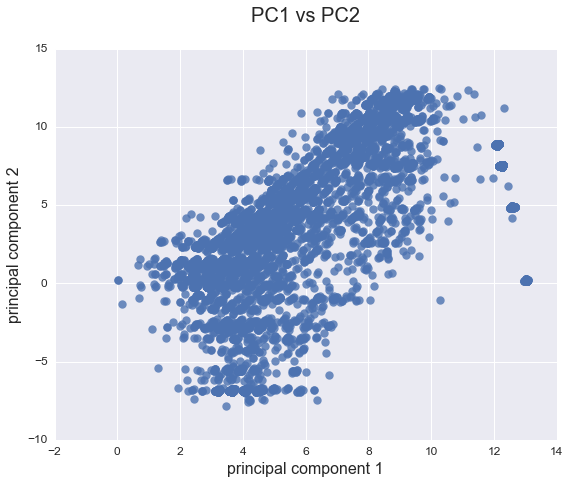

In [16]:
fig = plt.figure(figsize=(9,7))

ax = fig.gca()
ax = sns.regplot(Z.iloc[:,0], Z.iloc[:,1],
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('principal component 2', fontsize=16)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=20)

plt.show()

In [17]:
# Will now transform data so that PC1 and PC2 can be plotted with individual target variables...
# Need to do this in order to see which variables are more likely part of the principal components...

demo_2 = demo_w2

demo_pcs = demo_2.copy

demo_pcs = (demo_2 - demo_2.mean()) / demo_2.std()

demo_pcs['PC1'] = Z.iloc[:,0]
demo_pcs['PC2'] = Z.iloc[:,1]

In [18]:
demo_pcs = pd.melt(demo_pcs, id_vars=['PC1','PC2'])


In [19]:
demo_pcs.head()

,PC1,PC2,variable,value
0,2.475511,-0.110236,St,-1.396589
1,3.312546,-2.791570,St,-1.396589
2,2.475511,-0.110236,St,-1.396589
3,2.522670,-0.011041,St,-1.396589
4,3.772131,-2.728868,St,-1.396589


### PC1 vs Target Variables

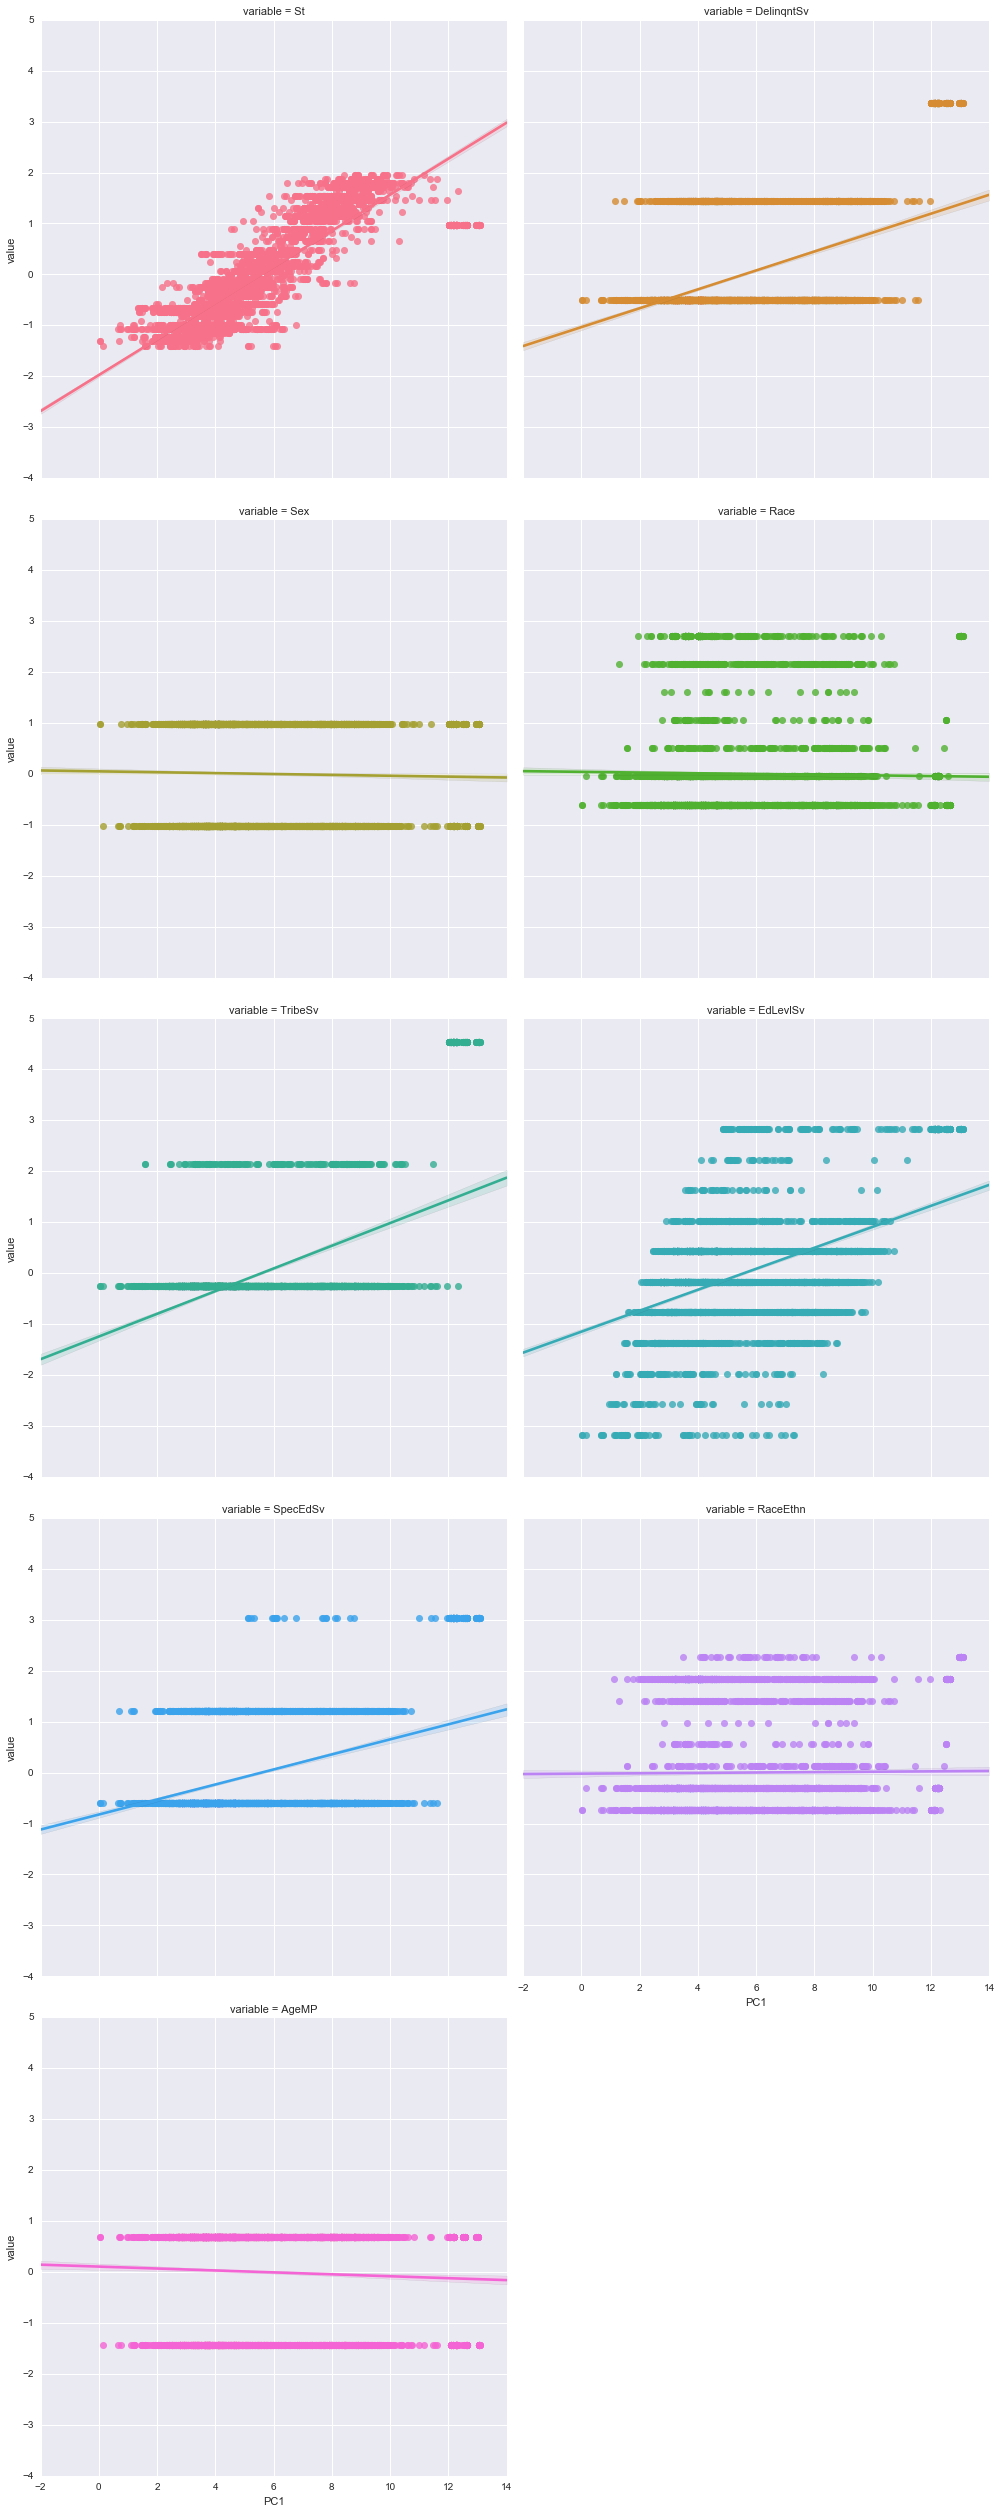

In [25]:
pc1 = sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=demo_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

### PC2 vs Target Variables

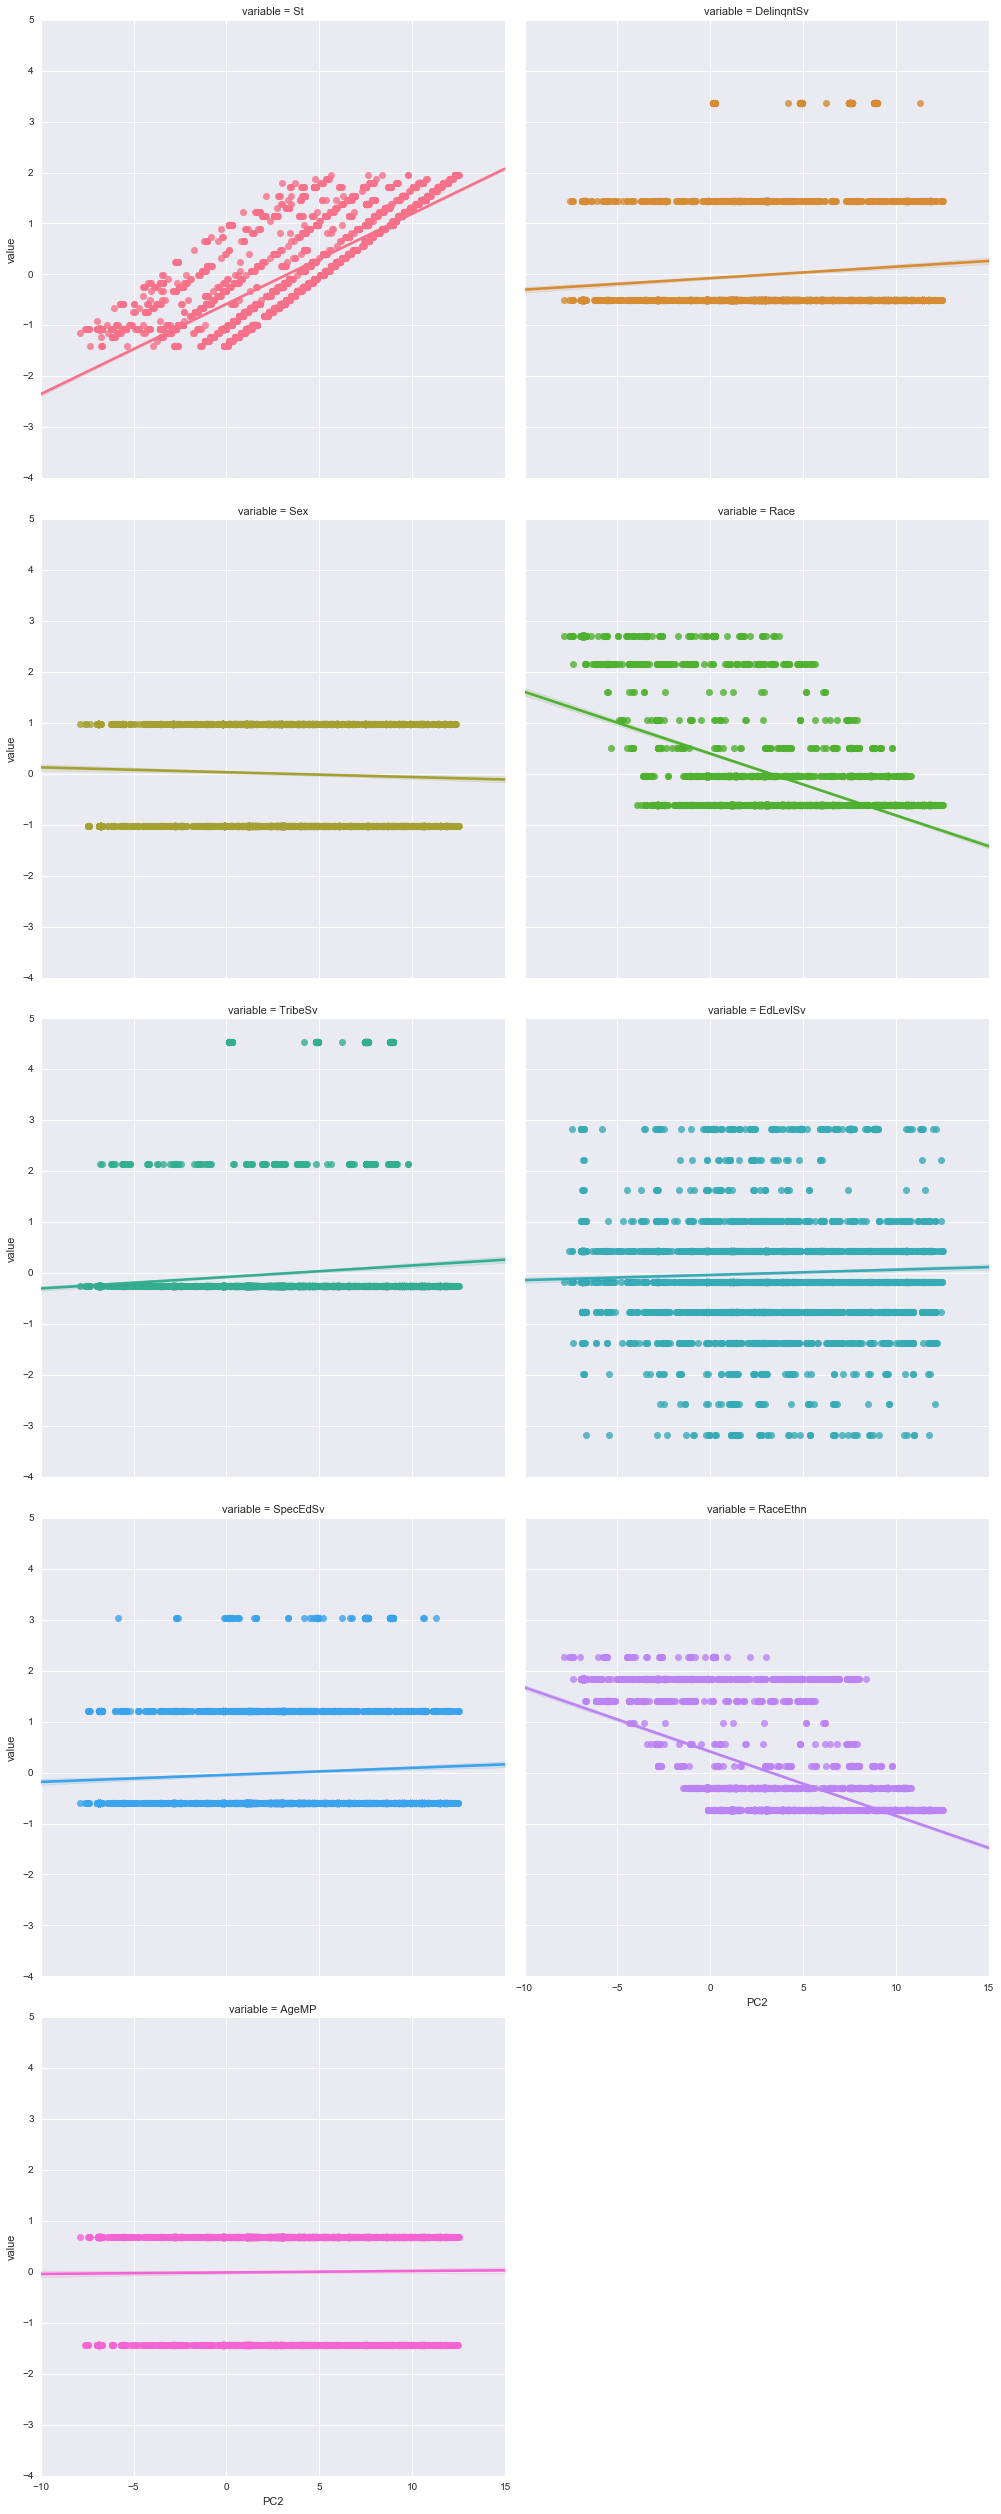

In [26]:
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=demo_pcs, col_wrap=2, size=7, scatter_kws={'s':50})


In [23]:
# From the PCAs so far, can see that HighEdCert should be the target variable for this project

### PC1 vs PC2 WITH LABELS

In [20]:
from sklearn.decomposition import PCA 

pcask = PCA(n_components=3)
print pcask.fit(demo_w2).components_ # See the eigenvectors
yPC = pcask.fit_transform(demo_w2) # Use the eigenvectors to transform xStand onto new axes

PCdf = pd.DataFrame(yPC, columns=['PC1','PC2','PC3'])

demo_2 = demographics_W2

demo_pca = demo_2.join(PCdf, on=None, how='left')

[[  9.99014298e-01   6.67454291e-03  -5.10373328e-04  -2.49656865e-02
    7.13918773e-03   1.39993031e-02   3.34760816e-03  -3.23137317e-02
   -7.29023593e-05]
 [  3.91256998e-02   1.87418026e-02   9.45780481e-03   5.59917440e-01
    2.78454346e-02   8.12849351e-02   6.99855638e-03   8.22843400e-01
   -4.25257316e-03]
 [ -1.93585742e-02   1.29283836e-01   1.00101792e-02  -6.41772871e-02
    1.30027005e-01   9.70175630e-01   1.30227507e-01  -5.98280394e-02
   -2.37382387e-03]]


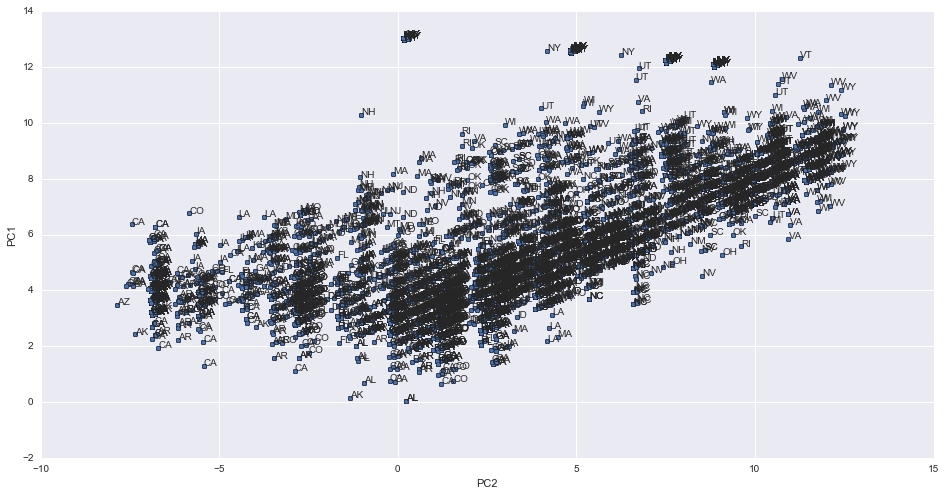

In [21]:
graph = demo_pcs.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, demo in enumerate(demographics_W2['St']):
    graph.annotate(demo, (demo_pcs.iloc[i].PC2, demo_pcs.iloc[i].PC1))

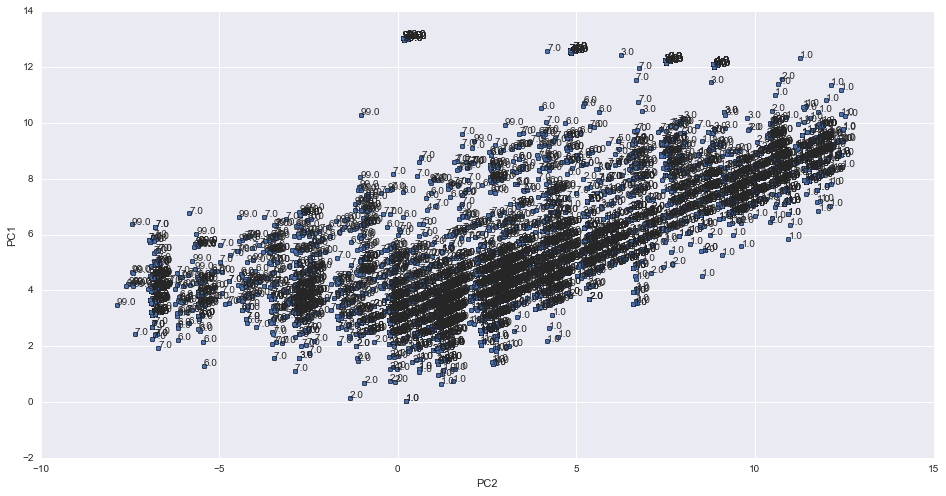

In [22]:
graph = demo_pcs.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, demo in enumerate(demographics_W2['RaceEthn']):
    graph.annotate(demo, (demo_pcs.iloc[i].PC2, demo_pcs.iloc[i].PC1))

In [23]:
from matplotlib.mlab import PCA
#construct your numpy array of data
myData = np.array(demo_w2) 
results = PCA(myData) 

#this will return an array of variance percentages for each component
results.fracs

#this will return a 2d array of the data projected into PCA space
results.Y 

array([[-0.91287181,  0.33250075, -0.97219982, ...,  0.30869986,
        -0.24769469, -0.09128983],
       [ 0.54746341, -1.00627101, -1.13367134, ...,  0.44690593,
        -1.578543  , -1.4147744 ],
       [-0.91287181,  0.33250075, -0.97219982, ...,  0.30869986,
        -0.24769469, -0.09128983],
       ..., 
       [-0.07726188,  1.47786547,  0.49576257, ..., -0.70443563,
         0.08051122,  0.00663174],
       [-0.78670057,  1.55586213,  0.43202085, ..., -0.24781868,
        -0.21835867, -0.19999781],
       [-0.62017113,  1.35309326, -1.52944539, ..., -0.09824366,
        -0.02063553,  0.09650206]])

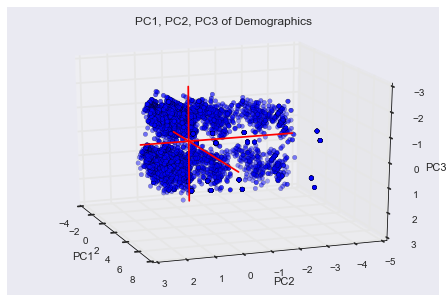

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = []
y = []
z = []
for item in results.Y:
 x.append(item[0])
 y.append(item[1])
 z.append(item[2])

plt.close('all') # close all latent plotting windows
fig1 = plt.figure() # Make a plotting figure
ax = Axes3D(fig1) # use the plotting figure to create a Axis3D object.
pltData = [x,y,z] 
ax.scatter(pltData[0], pltData[1], pltData[2], 'bo') # make a scatter plot of blue dots from the data
 
# make simple, bare axis lines through space:
xAxisLine = ((min(pltData[0]), max(pltData[0])), (0, 0), (0,0)) # 2 points make the x-axis line at the data extrema along x-axis 
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r') # make a red line for the x-axis.
yAxisLine = ((0, 0), (min(pltData[1]), max(pltData[1])), (0,0)) # 2 points make the y-axis line at the data extrema along y-axis
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r') # make a red line for the y-axis.
zAxisLine = ((0, 0), (0,0), (min(pltData[2]), max(pltData[2]))) # 2 points make the z-axis line at the data extrema along z-axis
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r') # make a red line for the z-axis.
 
# label the axes 
ax.set_xlabel("PC1") 
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PC1, PC2, PC3 of Demographics")


ax.azim = 200
ax.elev = 199


plt.show() # show the plot



# 3) Feature Importance over Demographics

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [14]:
targets_w2 = pd.read_csv('/Users/cguy/kelstuff/ga_summer_2016/targets_w2.csv')
targets_w2.head()

,Unnamed: 0,PubFoodAs,PubHousAs,OthrFinAs,HighEdCert,CurrFTE,CurrPTE,PubFinAs,CurrenRoll,PrescripIn,Homeless,SubAbuse,Incarc,Medicaid,OthrHlthIn,MedicalIn,MentlHlthIn
0,7328,4,2,2,7,2,2,2,2,4,3,2,2,4,4,4,4
1,7329,2,2,2,5,2,2,2,2,4,2,2,2,3,4,4,4
2,7330,4,2,2,5,2,2,2,3,4,2,3,3,4,4,4,4
3,7331,4,2,2,5,2,3,2,2,4,3,2,2,4,4,4,4
4,7332,4,2,2,5,3,2,2,2,4,3,2,2,4,5,2,4


In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

targets_w2_ = targets[targets.Wave == "Wave 2: Age 19 Followup"]
targets_w2_ = targets_w2_.drop('Wave', axis = 1)


targets_w2 = targets_w2_.copy()

for column in targets_w2:
    targets_w2[column] = le.fit_transform(targets_w2[column])
targets_w2.head()

/Users/cguy/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


,PubFoodAs,PubHousAs,OthrFinAs,HighEdCert,CurrFTE,CurrPTE,PubFinAs,CurrenRoll,PrescripIn,Homeless,SubAbuse,Incarc,Medicaid,OthrHlthIn,MedicalIn,MentlHlthIn
7328,4,2,2,7,2,2,2,2,4,3,2,2,4,4,4,4
7329,2,2,2,5,2,2,2,2,4,2,2,2,3,4,4,4
7330,4,2,2,5,2,2,2,3,4,2,3,3,4,4,4,4
7331,4,2,2,5,2,3,2,2,4,3,2,2,4,4,4,4
7332,4,2,2,5,3,2,2,2,4,3,2,2,4,5,2,4


In [16]:
targets_labels = targets[targets.Wave == "Wave 2: Age 19 Followup"]


In [17]:
# y = 0 v 1, 
    # where 1 = Vocational certificate (8), Vocational license (9), Associate's Degree (6), 
            #   Higher degree (1), Bachelor's Degree (2)
    # or 1 = when CurrenRoll == 3

def determine_Success(row):
    column_1 = 'HighEdCert'
    column_2 = 'CurrenRoll'
    if row[column_1] == 1:
        val = 1
    elif row[column_1] ==  2:
        val = 1
    elif row[column_1] ==  6:
        val = 1
    elif row[column_1] ==  9:
        val = 1
    elif row[column_1] ==  8:
        val = 1
    elif row[column_2] == 3:
        val = 1
    else:
        val = 0
    return val
    
targets_w2_final = targets_w2.copy()

targets_w2_final['Success'] = targets_w2_final.apply(determine_Success, axis=1)
targets_w2_final.head(10)



,PubFoodAs,PubHousAs,OthrFinAs,HighEdCert,CurrFTE,CurrPTE,PubFinAs,CurrenRoll,PrescripIn,Homeless,SubAbuse,Incarc,Medicaid,OthrHlthIn,MedicalIn,MentlHlthIn,Success
7328,4,2,2,7,2,2,2,2,4,3,2,2,4,4,4,4,0
7329,2,2,2,5,2,2,2,2,4,2,2,2,3,4,4,4,0
7330,4,2,2,5,2,2,2,3,4,2,3,3,4,4,4,4,1
7331,4,2,2,5,2,3,2,2,4,3,2,2,4,4,4,4,0
7332,4,2,2,5,3,2,2,2,4,3,2,2,4,5,2,4,0
7333,3,3,2,7,2,2,3,3,4,2,2,2,4,4,4,4,1
7334,3,3,2,7,2,2,3,3,5,2,2,2,4,5,5,5,1
7335,2,2,2,5,2,2,2,2,5,2,2,2,4,5,5,3,0
7336,4,2,2,7,3,2,2,2,4,3,2,3,4,4,4,4,0
7337,2,1,3,7,2,2,1,3,4,3,2,3,4,4,4,4,1


In [18]:
targets_w2_final['Success'].value_counts()

0    4830
1    2498
Name: Success, dtype: int64

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = targets_w2_final['Success']
X = pd.get_dummies(demographics_W2)

dem2 = demographics_W2.copy()

for column in dem2:
    dem2[column] = le.fit_transform(dem2[column])
dem2.head()


X2 = dem2

In [20]:
X2.head()

,St,DelinqntSv,Sex,Race,TribeSv,EdLevlSv,SpecEdSv,RaceEthn,AgeMP,Wave
7328,0,0,1,0,0,6,0,0,1,0
7329,0,0,1,2,1,6,0,2,1,0
7330,0,0,1,0,0,6,0,0,1,0
7331,0,0,0,0,0,6,0,0,1,0
7332,0,0,1,2,1,6,1,2,1,0


In [21]:
X.head()

,DelinqntSv,Sex,Race,TribeSv,EdLevlSv,SpecEdSv,RaceEthn,AgeMP,St_AK,St_AL,...,St_SC,St_SD,St_UT,St_VA,St_VT,St_WA,St_WI,St_WV,St_WY,Wave_Wave 2: Age 19 Followup
7328,0.0,2.0,1.0,0.0,11.0,0.0,1.0,17.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7329,0.0,2.0,3.0,1.0,11.0,0.0,3.0,17.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7330,0.0,2.0,1.0,0.0,11.0,0.0,1.0,17.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7331,0.0,1.0,1.0,0.0,11.0,0.0,1.0,17.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7332,0.0,2.0,3.0,1.0,11.0,1.0,3.0,17.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
y

7328     0
7329     0
7330     1
7331     0
7332     0
7333     1
7334     1
7335     0
7336     0
7337     1
7338     1
7339     0
7340     0
7341     1
7342     1
7343     0
7344     0
7345     0
7346     1
7347     0
7348     0
7349     1
7350     0
7351     0
7352     0
7353     1
7354     0
7355     0
7356     0
7357     1
        ..
14626    0
14627    0
14628    0
14629    0
14630    0
14631    0
14632    0
14633    0
14634    1
14635    0
14636    1
14637    1
14638    0
14639    0
14640    0
14641    0
14642    0
14643    0
14644    1
14645    0
14646    0
14647    0
14648    0
14649    0
14650    0
14651    0
14652    0
14653    0
14654    0
14655    1
Name: Success, dtype: int64

In [23]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2)

dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [24]:
pd.Series(y).value_counts()


0    4830
1    2498
Name: Success, dtype: int64

In [25]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
DelinqntSv,0.498111
St_LA,0.214667
St_IA,0.194104
St_NY,0.074570
RaceEthn,0.013844


In [26]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(-1, 51)

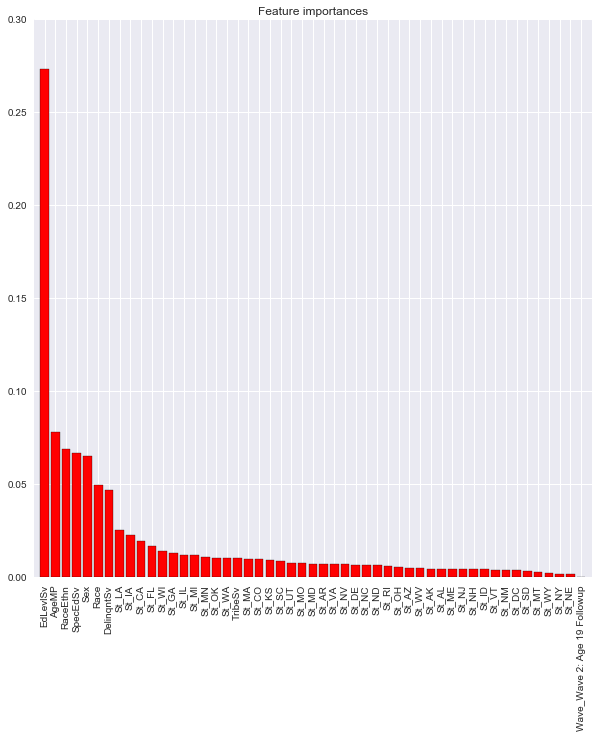

In [27]:
all(rf.feature_importances_ == np.mean([dt.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
# calculate the standard deviation of feature importances by looping over the trees in the random forest
# 
std = np.std([dt.feature_importances_ for tree in rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances of the forest
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])

,dt_importance,rf_importance,et_importance
EdLevlSv,0.186114,0.273512,0.328907
AgeMP,0.090776,0.078078,0.056356
RaceEthn,0.064365,0.069058,0.091607
SpecEdSv,0.070026,0.066829,0.071589
Sex,0.066004,0.065387,0.036446
Race,0.059861,0.049387,0.077074
DelinqntSv,0.049586,0.046910,0.060931
St_LA,0.021370,0.025221,0.027094
St_IA,0.021882,0.022957,0.031366
St_CA,0.018250,0.019543,0.016629


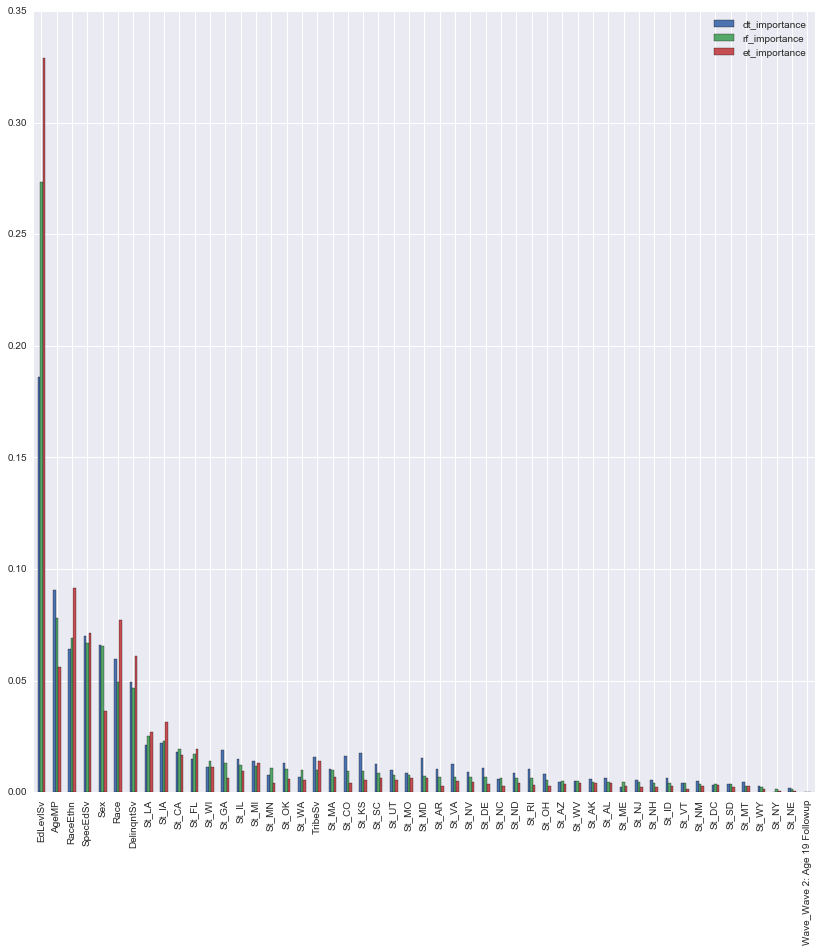

In [28]:
dt = DecisionTreeClassifier()
dt.fit(X, y)

et.fit(X, y)

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)

                           
importances.plot(kind='bar', figsize=(14,14))
importances.head(10)

In [29]:
importances_dt = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('dt_importance',
                                                                   ascending=False)

                           
importances_dt.head(10)

,dt_importance,rf_importance,et_importance
EdLevlSv,0.186114,0.273512,0.328907
AgeMP,0.090776,0.078078,0.056356
SpecEdSv,0.070026,0.066829,0.071589
Sex,0.066004,0.065387,0.036446
RaceEthn,0.064365,0.069058,0.091607
Race,0.059861,0.049387,0.077074
DelinqntSv,0.049586,0.046910,0.060931
St_IA,0.021882,0.022957,0.031366
St_LA,0.021370,0.025221,0.027094
St_GA,0.018861,0.013215,0.006332


In [30]:
importances_et = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('et_importance',
                                                                   ascending=False)

                           
importances_et.head(10)

,dt_importance,rf_importance,et_importance
EdLevlSv,0.186114,0.273512,0.328907
RaceEthn,0.064365,0.069058,0.091607
Race,0.059861,0.049387,0.077074
SpecEdSv,0.070026,0.066829,0.071589
DelinqntSv,0.049586,0.046910,0.060931
AgeMP,0.090776,0.078078,0.056356
Sex,0.066004,0.065387,0.036446
St_IA,0.021882,0.022957,0.031366
St_LA,0.021370,0.025221,0.027094
St_FL,0.014783,0.016990,0.019281


# Now with X2

In [31]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2)

dt.fit(X2, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [32]:
pd.Series(y).value_counts()


0    4830
1    2498
Name: Success, dtype: int64

In [33]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X2.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
St,0.562136
DelinqntSv,0.336571
TribeSv,0.050387
Race,0.041551
RaceEthn,0.009354


In [34]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X2, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(-1, 10)

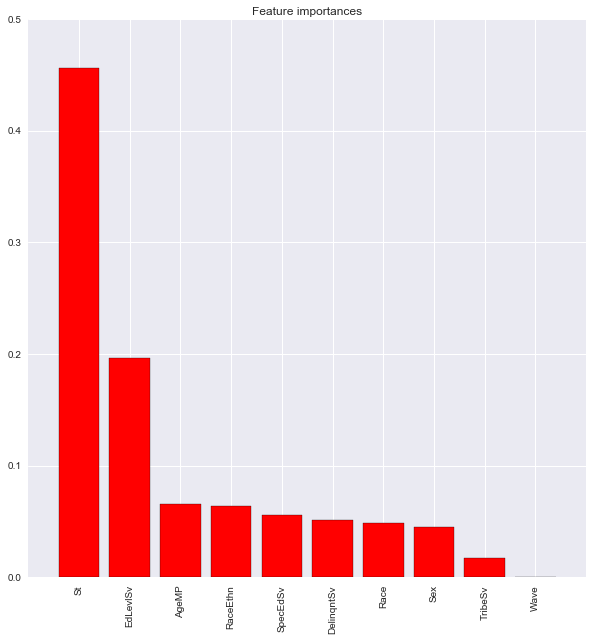

In [35]:
all(rf.feature_importances_ == np.mean([dt.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
# calculate the standard deviation of feature importances by looping over the trees in the random forest
# 
std = np.std([dt.feature_importances_ for tree in rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X2.columns

# Plot the feature importances of the forest
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(X2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X2.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X2.shape[1]])

,dt_importance,rf_importance,et_importance
St,0.330698,0.456333,0.502771
EdLevlSv,0.189342,0.196760,0.238226
AgeMP,0.124657,0.065514,0.029435
RaceEthn,0.076444,0.063596,0.047298
SpecEdSv,0.081298,0.055842,0.035328
DelinqntSv,0.049586,0.051443,0.066148
Race,0.058008,0.048585,0.040060
Sex,0.063020,0.044684,0.026499
TribeSv,0.026946,0.017244,0.014235
Wave,0.000000,0.000000,0.000000


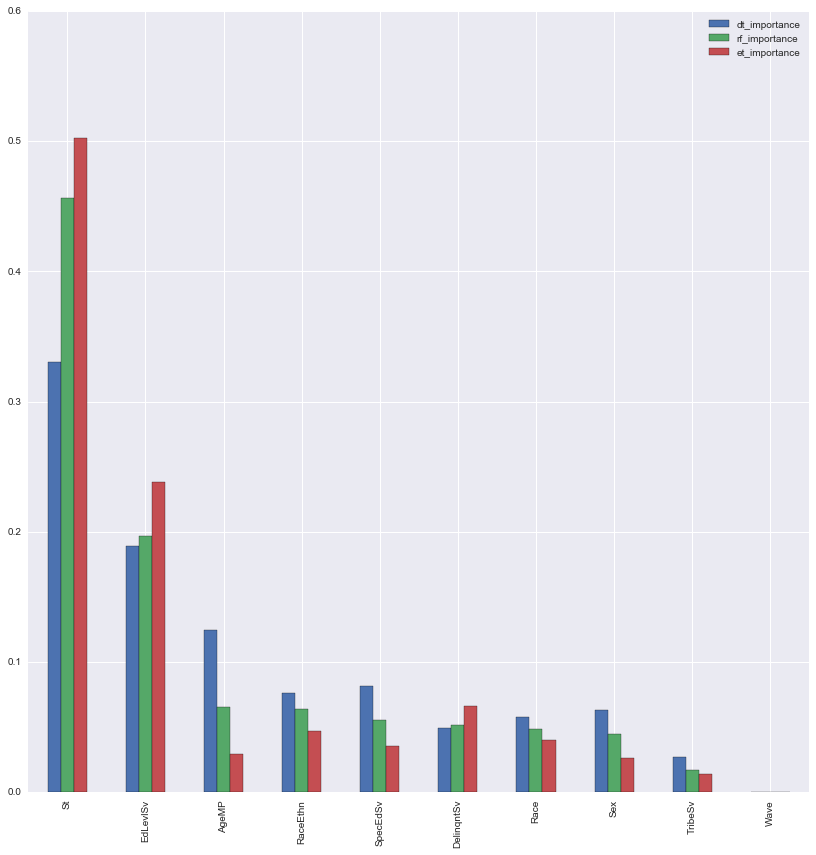

In [40]:
dt = DecisionTreeClassifier()
dt.fit(X2, y)

et.fit(X2, y)

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X2.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)

                           
importances.plot(kind='bar', figsize=(14,14))
importances.head(10)

In [44]:
importances_dt = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X2.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('dt_importance',
                                                                   ascending=False)

                           
importances_dt.head(10)

,dt_importance,rf_importance,et_importance
St,0.330698,0.456333,0.502771
EdLevlSv,0.189342,0.196760,0.238226
AgeMP,0.124657,0.065514,0.029435
SpecEdSv,0.081298,0.055842,0.035328
RaceEthn,0.076444,0.063596,0.047298
Sex,0.063020,0.044684,0.026499
Race,0.058008,0.048585,0.040060
DelinqntSv,0.049586,0.051443,0.066148
TribeSv,0.026946,0.017244,0.014235
Wave,0.000000,0.000000,0.000000


In [45]:
importances_et = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X2.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('et_importance',
                                                                   ascending=False)

                           
importances_et.head(10)

,dt_importance,rf_importance,et_importance
St,0.330698,0.456333,0.502771
EdLevlSv,0.189342,0.196760,0.238226
DelinqntSv,0.049586,0.051443,0.066148
RaceEthn,0.076444,0.063596,0.047298
Race,0.058008,0.048585,0.040060
SpecEdSv,0.081298,0.055842,0.035328
AgeMP,0.124657,0.065514,0.029435
Sex,0.063020,0.044684,0.026499
TribeSv,0.026946,0.017244,0.014235
Wave,0.000000,0.000000,0.000000
